# LSTM for CPI prediction

Imports

In [139]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Third-party library imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Data preparation

In [266]:
# Load dataset
data = pd.read_csv('Monthly_data.csv')

# Preprocess data
# Remove unnecessary columns and handle missing values
data.drop(columns=['12 Month MA / Current Inflation'], inplace=True)  # Drop unwanted column
data.drop(columns=['Year and Month'], inplace=True)  # Drop unwanted column
data.dropna(inplace=True)  # Remove rows with missing values

# Setup for prediction task
lag = 3  # Number of months ahead to predict
column_name = f'CPI {lag} Month{"s" if lag > 1 else ""} ahead'
data[column_name] = data['CPI'].shift(-lag)  # Target variable for prediction

# Select features and target for modeling
# Excludes 'Year and Month' from features and uses dynamically selected last column as the target
features = data.columns[1:-1]  # Features selection
target = data.columns[-1]  # Target variable

# Initialize and apply MinMaxScaler
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])  # Scale features
data[[target]] = scaler.fit_transform(data[[target]])  # Scale target variable separately

# Now, `data` is ready for machine learning model input

data 

,CPI,Interest rate,GDP growth,Total pay nominal,Unemployment,USD/GBP,12 Month MA - current,M3 growth,Brent,CPI 3 Months ahead
11,1.5,0.690265,0.555256,0.516949,0.326531,0.311263,0.503960,0.357143,0.016617,0.080357
12,1.5,0.690265,0.555256,0.500000,0.326531,0.310624,0.509901,0.371429,0.046528,0.062500
13,1.4,0.690265,0.560647,0.500000,0.326531,0.332872,0.523762,0.300000,0.064282,0.107143
14,0.8,0.690265,0.560647,0.525424,0.326531,0.349798,0.586139,0.385714,0.060959,0.098214
15,0.6,0.690265,0.560647,0.559322,0.326531,0.378539,0.599010,0.257143,0.049851,0.098214
...,...,...,...,...,...,...,...,...,...,...
269,6.7,0.911504,0.544474,0.940678,0.102041,0.149031,0.832673,0.342857,0.592706,0.357143
270,6.7,0.911504,0.544474,0.923729,0.081633,0.115180,0.799010,0.228571,0.658912,0.366071
271,4.6,0.911504,0.539084,0.855932,0.061224,0.091654,0.984158,0.157143,0.631625,NaN
272,3.9,0.911504,0.539084,0.813559,0.040816,0.119544,1.000000,0.400000,0.564632,NaN


Data used to make predictions

In [268]:
# Define parameters for the sequence and prediction
sequence_length = 20  # The length of input sequences for the model
test_split = 0.2  # Fraction of the data to be used as the test set

# Copy the original DataFrame to preserve the original data
data_for_prediction = data.copy()

# Select the final sequence of data for making future predictions
# This dataset will be used to predict the future value(s) outside of the available dataset
data_for_prediction = data_for_prediction.iloc[-( sequence_length + lag - 1):, :]

# Prepare the dataset for training and testing the model
# Exclude the last part used for prediction to ensure we are only working with historical data
data_for_model = data.iloc[:-lag , :]

# Split the historical data into training and testing datasets
# Determine the index to split the data
test_data_size = int(len(data_for_model) * test_split)

# Split the data into training and testing sets
train_data = data_for_model[:-test_data_size]
test_data = data_for_model[-test_data_size:]

# Display the prepared training data
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

data_for_model


Training data shape: (208, 10)
Testing data shape: (52, 10)


,CPI,Interest rate,GDP growth,Total pay nominal,Unemployment,USD/GBP,12 Month MA - current,M3 growth,Brent,CPI 3 Months ahead
11,1.5,0.690265,0.555256,0.516949,0.326531,0.311263,0.503960,0.357143,0.016617,0.080357
12,1.5,0.690265,0.555256,0.500000,0.326531,0.310624,0.509901,0.371429,0.046528,0.062500
13,1.4,0.690265,0.560647,0.500000,0.326531,0.332872,0.523762,0.300000,0.064282,0.107143
14,0.8,0.690265,0.560647,0.525424,0.326531,0.349798,0.586139,0.385714,0.060959,0.098214
15,0.6,0.690265,0.560647,0.559322,0.326531,0.378539,0.599010,0.257143,0.049851,0.098214
...,...,...,...,...,...,...,...,...,...,...
266,8.7,0.778761,0.547170,0.855932,0.122449,0.124122,0.674257,0.328571,0.499300,0.607143
267,7.9,0.867257,0.547170,0.957627,0.142857,0.140941,0.754455,0.328571,0.493790,0.607143
268,6.8,0.867257,0.544474,0.966102,0.122449,0.167554,0.852475,0.214286,0.539881,0.419643
269,6.7,0.911504,0.544474,0.940678,0.102041,0.149031,0.832673,0.342857,0.592706,0.357143


Create the sequences from the features and target

In [269]:
def create_sequences(data, input_columns, target_column, sequence_length):
    """Create sequences of input features and target values."""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Extract the sequence of input features
        X.append(data[input_columns].iloc[i:i+sequence_length].values)
        # Extract the target value following the sequence
        y.append(data[target_column].iloc[i+sequence_length])
    
    return np.array(X), np.array(y)

# Specify the input and target columns
input_columns = features 
target_column = target  

# Generate sequences for the LSTM model
X_train, y_train = create_sequences(train_data, input_columns, target_column, sequence_length)
X_test, y_test = create_sequences(test_data, input_columns, target_column, sequence_length)

# Output the shape of the training data sequences for verification
print("Training data sequences shape:", X_train.shape)
print("Test data sequences shape:", X_test.shape)

Training data sequences shape: (188, 20, 8)
Test data sequences shape: (32, 20, 8)


Model 1 - One LSTM layer

In [270]:
model = Sequential([
    LSTM(100, activation='tanh', recurrent_activation='sigmoid',
         input_shape=(X_train.shape[1], X_train.shape[2]),
         dropout=0.05, recurrent_dropout=0.05),
    Dense(1)
])

# Trying the Adam optimizer
model.compile(optimizer='adam', loss='mse')

model.summary()

'''
# Split your data into training and validation sets
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Then, use the `validation_data` parameter in `model.fit()`
history = model.fit(X_train_part, y_train_part, epochs=100, validation_data=(X_val, y_val), batch_size=32)
'''

# Include validation split for training monitoring
history = model.fit(X_train, y_train, epochs=500, validation_split=0.05, batch_size=32)

train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Testing Loss: {test_loss}')



Model: "sequential_253"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_253 (LSTM)             (None, 100)               43600     
                                                                 
 dense_253 (Dense)           (None, 1)                 101       
                                                                 
Total params: 43701 (170.71 KB)
Trainable params: 43701 (170.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 3s 86ms/step - loss: 0.0452 - val_loss: 0.0169
Epoch 2/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0145 - val_loss: 0.0022
Epoch 3/500
6/6 [==============================] - 0s 45ms/step - loss: 0.0170 - val_loss: 2.4122e-04
Epoch 4/500
6/6 [==============================] - 0s 26ms/step - loss: 0.0102 - val_loss: 0.0020
Epoch 5/500
6/

Model 2 - Two LSTM layers

In [ ]:
'''
# Model architecture

model = Sequential([
    # First LSTM layer returns sequences to feed into the next LSTM layer
    LSTM(20, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2]), return_sequences=True),
    # Second LSTM layer only needs to return the last output
    LSTM(2, activation='relu'),
    # Followed by a Dense layer that makes the final prediction
    Dense(1)
])

model.compile(optimizer='sgd', loss='mse')

# Model summary
model.summary()

# Fit the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Testing Loss: {test_loss}')
'''

In [279]:
n_iterations = 3
train_losses = []
test_losses = []

for i in range(n_iterations):
    print(f"Running iteration: {i+1}/{n_iterations}")
    
    # Re-initialize the model at each iteration
    model = Sequential([
        LSTM(200, activation='tanh', recurrent_activation='sigmoid',
             input_shape=(X_train.shape[1], X_train.shape[2]),
             dropout=0.05, recurrent_dropout=0.05),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # Fit the model
    model.fit(X_train, y_train, epochs=200, validation_split=0.0, batch_size=32, verbose=0)  # Set verbose=0 for less output
    
    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Store losses
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Calculate the average losses
average_train_loss = np.mean(train_losses)
average_test_loss = np.mean(test_losses)

print(f'Average Training Loss: {average_train_loss}')
print(f'Average Testing Loss: {average_test_loss}')


Running iteration: 1/3


Visuallise training loss vs validation loss

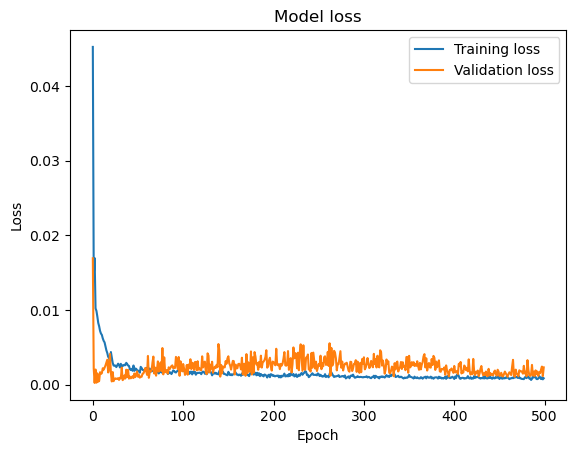

In [271]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


Predictions

In [255]:
X_full, y_full = create_sequences(data_for_model, input_columns, target_column, sequence_length)

model = Sequential([
    LSTM(200, activation='tanh', recurrent_activation='sigmoid',
         input_shape=(X_train.shape[1], X_train.shape[2]),
         dropout=0.1, recurrent_dropout=0.1),
    Dense(1)
])

# Trying the Adam optimizer
model.compile(optimizer='adam', loss='mse')

model.fit(X_full, y_full, epochs=200, validation_split=0.0, batch_size=32, verbose=0)

def create_sequences_X(data, input_columns, sequence_length):
    X= []
    for i in range(lag):
        X.append(data[input_columns].iloc[i:i+sequence_length].values)
    
    return np.array(X)

input_columns = features

X_prediction = create_sequences_X(data_for_prediction, input_columns, sequence_length)

predicted_cpi = model.predict(X_prediction)

predicted_cpi_inverted = scaler.inverse_transform(predicted_cpi)

predicted_cpi_inverted




1/1 [==============================] - 0s 349ms/step


array([[3.304046]], dtype=float32)

In [ ]:
'''
def build_and_evaluate_model(n_units, X_train, y_train, X_test, y_test):
    model = Sequential([
        LSTM(n_units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='sgd', loss='mse')
    model.fit(X_train, y_train, epochs=1000, validation_split=0.006, batch_size=32, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    return test_loss

units_list = list([50,100, 150,200, 250, 300, 350, 400, 450, 500])
test_losses = []

for units in units_list:
    test_loss = build_and_evaluate_model(units, X_train, y_train, X_test, y_test)
    test_losses.append(test_loss)
    print(f"Test loss with {units} units: {test_loss}")

# Plotting the test loss vs. number of units
plt.figure(figsize=(10, 6))
plt.plot(units_list, test_losses, marker='o', linestyle='-', color='b')
plt.title('Test Loss vs. Number of LSTM Units')
plt.xlabel('Number of LSTM Units')
plt.ylabel('Test Loss (MSE)')
plt.grid(True)
plt.show()
'''
